# What's in a Name?

In [1]:
import warnings
# Ignore numpy dtype warnings. These warnings are caused by an interaction
# between numpy and Cython and can be safely ignored.
# Reference: https://stackoverflow.com/a/40846742
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
import nbinteract as nbi

sns.set()
sns.set_context('talk')
np.set_printoptions(threshold=20, precision=2, suppress=True)
pd.set_option('display.max_rows', 7)
pd.set_option('display.max_columns', 8)
pd.set_option('precision', 2)
# This option stops scientific notation for pandas
# pd.set_option('display.float_format', '{:.2f}'.format)

In [2]:
def df_interact(df, nrows=7, ncols=7):
    '''
    Outputs sliders that show rows and columns of df
    '''
    def peek(row=0, col=0):
        return df.iloc[row:row + nrows, col:col + ncols]

    row_arg = (0, len(df), nrows) if len(df) > nrows else fixed(0)
    col_arg = ((0, len(df.columns), ncols)
               if len(df.columns) > ncols else fixed(0))
    
    interact(peek, row=row_arg, col=col_arg)
    print('({} rows, {} columns) total'.format(df.shape[0], df.shape[1]))

def display_df(df, rows=pd.options.display.max_rows,
               cols=pd.options.display.max_columns):
    with pd.option_context('display.max_rows', rows,
                           'display.max_columns', cols):
        display(df)

In [8]:
import pandas as pd

students = (pd.read_csv('names.csv', header=0,
                        names=['timestamp', 'name', 'sex', 'age'])
            .assign(name=lambda df: df['name'].str.lower())
            .replace({'Male': 'M', 'Female': 'F'}))
students

,timestamp,name,sex,age
0,1/25/2020 21:09:45,samuel,M,24


In [9]:
students['name']

0    samuel
Name: name, dtype: object

In [10]:
len(students)

1

In [11]:
students['sex'].value_counts().to_frame()

,sex
M,1


In [ ]:
sns.distplot(students['name'].str.len(),
             rug=True,
             bins=np.arange(12),
             axlabel="Number of Characters")
plt.xlim(0, 12)
plt.xticks(np.arange(12))
plt.ylabel('Proportion per character');

## What's in a Name?

In [13]:
students['name'][0]

'samuel'

In [14]:
babynames = pd.read_csv('babynames.csv')
babynames

,Name,Sex,Count,Year
0,Mary,F,7065,1880
1,Anna,F,2604,1880
2,Emma,F,2003,1880
...,...,...,...,...
1957043,Zyrie,M,5,2018
1957044,Zyron,M,5,2018
1957045,Zzyzx,M,5,2018


https://www.ssa.gov/oact/babynames/background.html

> All names are from Social Security card applications for births that occurred in the United States after 1879. Note  that many people born before 1937 never applied for a Social Security card, so their names are not included in our data. For others who did apply, our records may not show the place of birth, and again their names are not included in our data.
> 
> All data are from a 100% sample of our records on Social Security card applications as of March 2019.

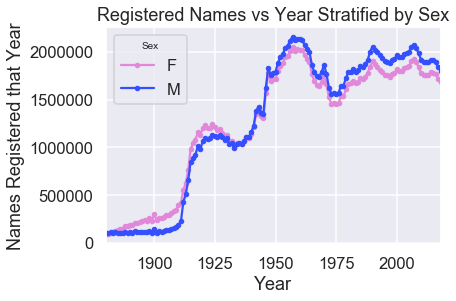

In [15]:
pivot_year_name_count = pd.pivot_table(
    babynames, index='Year', columns='Sex',
    values='Count', aggfunc=np.sum)

pink_blue = ["#E188DB", "#334FFF"]
with sns.color_palette(sns.color_palette(pink_blue)):
    pivot_year_name_count.plot(marker=".")
    plt.title("Registered Names vs Year Stratified by Sex")
    plt.ylabel('Names Registered that Year')

In [16]:
babynames['Name'] = babynames['Name'].str.lower()
babynames

,Name,Sex,Count,Year
0,mary,F,7065,1880
1,anna,F,2604,1880
2,emma,F,2003,1880
...,...,...,...,...
1957043,zyrie,M,5,2018
1957044,zyron,M,5,2018
1957045,zzyzx,M,5,2018


In [17]:
sex_counts = pd.pivot_table(babynames, index='Name', columns='Sex', values='Count',
                            aggfunc='sum', fill_value=0., margins=True)
sex_counts

Sex,F,M,All
Name,,,
aaban,0,114,114
aabha,35,0,35
aabid,0,16,16
...,...,...,...
zyyon,0,6,6
zzyzx,0,10,10
All,174079232,177573793,351653025


In [18]:
prop_female = sex_counts['F'] / sex_counts['All']
sex_counts['prop_female'] = prop_female
sex_counts

Sex,F,M,All,prop_female
Name,,,,
aaban,0,114,114,0.0
aabha,35,0,35,1.0
aabid,0,16,16,0.0
...,...,...,...,...
zyyon,0,6,6,0.0
zzyzx,0,10,10,0.0
All,174079232,177573793,351653025,0.5


In [19]:
def sex_from_name(name):
    if name in sex_counts.index:
        prop = sex_counts.loc[name, 'prop_female']
        return 'F' if prop > 0.5 else 'M'
    else:
        return 'Name not in dataset'

sex_from_name('sam')

'M'

In [20]:
interact(sex_from_name, name='sam');

interactive(children=(Text(value='sam', description='name'), Output()), _dom_classes=('widget-interact',))

In [21]:
students['predicted_sex'] = students['name'].apply(sex_from_name)
students

,timestamp,name,sex,age,predicted_sex
0,1/25/2020 21:09:45,samuel,M,24,M


In [22]:
students['predicted_sex'].value_counts().to_frame().sort_index()

,predicted_sex
M,1


In [23]:
def avg_year(group):
    return np.average(group['Year'], weights=group['Count'])

avg_years = (
    babynames
    .groupby('Name')
    .apply(avg_year)
    .rename('avg_year')
    .to_frame()
)
avg_years

,avg_year
Name,
aaban,2013.33
aabha,2013.71
aabid,2012.69
...,...
zyyanna,2010.00
zyyon,2014.00
zzyzx,2014.00


In [24]:
def year_from_name(name):
    return (avg_years.loc[name, 'avg_year']
            if name in avg_years.index
            else None)

# Generate input box for you to try some names out:
interact(year_from_name, name='fernando');

interactive(children=(Text(value='fernando', description='name'), Output()), _dom_classes=('widget-interact',)…

In [25]:
students['predicted_year'] = students['name'].apply(year_from_name)
students.head()

,timestamp,name,sex,age,predicted_sex,predicted_year
0,1/25/2020 21:09:45,samuel,M,24,M,1975.83


In [ ]:
sns.distplot(students['predicted_year'].dropna(), bins=15);

In [27]:
students['predicted_year'].mean()

1975.8323089670507

## Why might our age estimate be inaccurate?

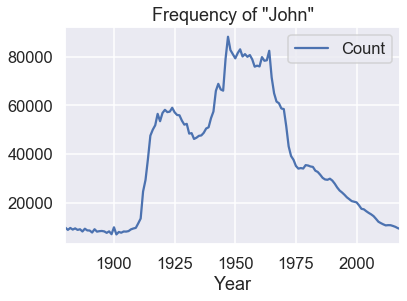

In [28]:
names = babynames.set_index('Name').sort_values('Year')
john = names.loc['john']
john[john['Sex'] == 'M'].plot('Year', 'Count')
plt.title('Frequency of "John"');

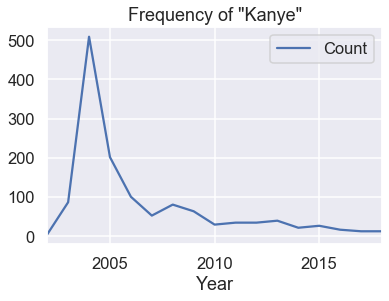

In [29]:
names = babynames.set_index('Name').sort_values('Year')
kanye = names.loc['kanye']
kanye[kanye['Sex'] == 'M'].plot('Year', 'Count')
plt.title('Frequency of "Kanye"');

## Hey Siri?

In [30]:
def plot_name(name, xlim=None, xline=None):
    names.loc[name].groupby('Year').sum().plot()
    plt.title(f'Frequency of "{name}"')
    if xlim: plt.xlim(xlim)
    if xline: plt.axvline(xline, c='red')

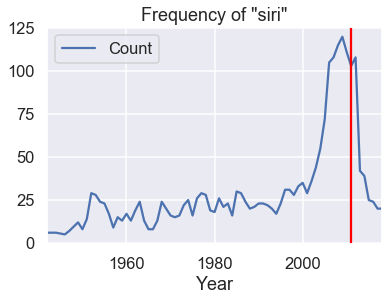

In [31]:
plot_name('siri', xline=2011)

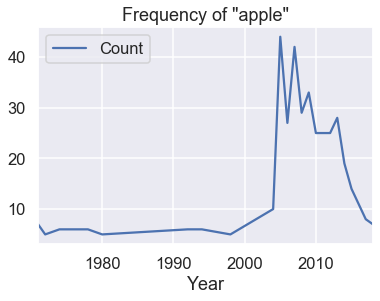

In [32]:
plot_name('apple')